In [279]:
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

In [280]:
MODELS_DIR = 'models/'
TEXTURES_DIR = 'textures/'
MODELS_NAMES = [
    'test',
    'body',
    'diablo3_pose',
    'african_head',
]
OUTPUT_DIRS = [
    'project_output/step_1/',
    'project_output/step_2/',
    'project_output/step_3/',
]

WIDTH, HEIGHT = 800, 800
LIGHT_DIR = np.array([-0.25, 0, -1])

In [281]:
for output_dir in OUTPUT_DIRS:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

<h1>Reading a model</h1>

In [282]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [283]:
import numpy as np

def rotate_vertex(vertex, rotation_matrix):
    """Applies a rotation matrix to a 3D vertex."""
    return tuple(np.dot(rotation_matrix, np.array(vertex)))

def get_rotation_matrix(axis, angle):
    """Returns a 3D rotation matrix for a given axis ('x', 'y', 'z') and angle in degrees."""
    angle_rad = np.radians(angle)
    if axis == 'x':
        return np.array([
            [1, 0, 0],
            [0, np.cos(angle_rad), -np.sin(angle_rad)],
            [0, np.sin(angle_rad), np.cos(angle_rad)]
        ])
    elif axis == 'y':
        return np.array([
            [np.cos(angle_rad), 0, np.sin(angle_rad)],
            [0, 1, 0],
            [-np.sin(angle_rad), 0, np.cos(angle_rad)]
        ])
    elif axis == 'z':
        return np.array([
            [np.cos(angle_rad), -np.sin(angle_rad), 0],
            [np.sin(angle_rad), np.cos(angle_rad), 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Invalid axis! Choose 'x', 'y', or 'z'.")

def parse_obj(filename, rotation_axis=None, rotation_angle=0):
    vertices = []
    faces = []
    edges = []
    uvs = []

    rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle) if rotation_axis else np.eye(3)

    with open(filename, 'r') as file:
        for line in file:
            parts = line.split()
            if not parts:
                continue

            if parts[0] == 'v':
                vertex = (float(parts[1]), float(parts[2]), float(parts[3]))
                rotated_vertex = rotate_vertex(vertex, rotation_matrix)
                vertices.append(rotated_vertex)
            elif parts[0] == 'vt':
                uvs.append((float(parts[1]), float(parts[2])))
            elif parts[0] == 'f':
                face_vertices = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                for i in range(len(face_vertices)):
                    v0 = face_vertices[i]
                    v1 = face_vertices[(i + 1) % len(face_vertices)]
                    edges.append((v0, v1))

                face_uvs = []
                for part in parts[1:]:
                    indices = part.split('/')
                    vt_idx = int(indices[1]) - 1 if len(indices) > 1 and indices[1] else None
                    face_uvs.append(vt_idx)

                faces.append((face_vertices, face_uvs))

    return vertices, edges, faces, uvs

In [284]:
def project_vertex(vertex, width, height):
    x, y, z = vertex

    x_screen = (x + 1) * 0.5 * width   # Scale x to screen space
    y_screen = (1 - y) * 0.5 * height  # Scale y to screen space (flip Y)
    return int(x_screen), int(y_screen), z  # Keep original z-depth for ordering

In [285]:
def render_model(vertices, edges, width, height, output_filename):
    image = Image.new('RGB', (width, height), 'white')
    pixels = image.load()

    for edge in edges:
        v0, v1 = edge
        x0, y0, _ = project_vertex(vertices[v0], width, height)
        x1, y1, _ = project_vertex(vertices[v1], width, height)
        for x, y in bresenham_line(x0, y0, x1, y1):
            if 0 <= x < width and 0 <= y < height:
                pixels[x, y] = (0, 0, 0)

    image.save(output_filename)

In [286]:
for name in MODELS_NAMES:
    model_path = f"{MODELS_DIR}{name}.obj"
    vertices, edges, _, _ = parse_obj(filename=model_path)
    out_path = f"{OUTPUT_DIRS[0]}{name}.png"
    render_model(vertices, edges, WIDTH, HEIGHT, out_path)

<h1>Rendering triangles</h1>

In [287]:
def draw_filled_triangle(v0, v1, v2, uv0, uv1, uv2, image, color, intensity, z_buffer=None, texture=None):
    # Get texture dimensions
    has_texture = texture is not None
    texture_width, texture_height = None, None
    if has_texture:
        texture_width, texture_height = texture.size

    # Sort vertices by y-coordinate
    vertices = sorted(zip([v0, v1, v2], [uv0, uv1, uv2]), key=lambda v: v[0][1])
    (x0, y0, z0), (u0, v0) = vertices[0]
    (x1, y1, z1), (u1, v1) = vertices[1]
    (x2, y2, z2), (u2, v2) = vertices[2]

    def interpolate(y, y0, x0, z0, u0, v0, y1, x1, z1, u1, v1):
        if y1 == y0:
            return x0, z0, u0, v0
        t = (y - y0) / (y1 - y0)
        x = x0 + t * (x1 - x0)
        z = z0 + t * (z1 - z0)
        u = u0 + t * (u1 - u0)
        v = v0 + t * (v1 - v0)
        return x, z, u, v

    def draw_scanline(y, x_start, x_end, z_start, z_end, u_start, v_start, u_end, v_end):
        # Draw the scanline, updating the Z-buffer if needed
        for x in range(int(x_start), int(x_end) + 1):
            t = (x - x_start) / (x_end - x_start) if x_end != x_start else 0
            z = z_start + t * (z_end - z_start)
            u = u_start + t * (u_end - u_start)
            v = v_start + t * (v_end - v_start)

            if 0 <= x < image.width and 0 <= y < image.height:
                if z_buffer is None or z > z_buffer[x, y]:
                    if has_texture:
                        tex_x = int(u * texture_width) % texture_width
                        tex_y = int((1 - v) * texture_height) % texture_height
                        pixel_color = tuple(int(channel * intensity) for channel in texture.getpixel((tex_x, tex_y))[:3])
                    else:
                        pixel_color = color

                    image.putpixel((x, y), pixel_color)
                    if z_buffer is not None:
                        z_buffer[x, y] = z

    for y in range(int(y0), int(y1) + 1):
        x_start, z_start, u_start, v_start = interpolate(y, y0, x0, z0, u0, v0, y2, x2, z2, u2, v2)
        x_end, z_end, u_end, v_end = interpolate(y, y0, x0, z0, u0, v0, y1, x1, z1, u1, v1)
        if x_start > x_end:
            x_start, x_end = x_end, x_start
            z_start, z_end = z_end, z_start
            u_start, u_end = u_end, u_start
            v_start, v_end = v_end, v_start
        draw_scanline(y, x_start, x_end, z_start, z_end, u_start, v_start, u_end, v_end)

    for y in range(int(y1) + 1, int(y2) + 1):
        x_start, z_start, u_start, v_start = interpolate(y, y1, x1, z1, u1, v1, y2, x2, z2, u2, v2)
        x_end, z_end, u_end, v_end = interpolate(y, y0, x0, z0, u0, v0, y2, x2, z2, u2, v2)
        if x_start > x_end:
            x_start, x_end = x_end, x_start
            z_start, z_end = z_end, z_start
            u_start, u_end = u_end, u_start
            v_start, v_end = v_end, v_start
        draw_scanline(y, x_start, x_end, z_start, z_end, u_start, v_start, u_end, v_end)

    return z_buffer

In [288]:
def render_model_with_rotations(name, texture, intensities, normals):
    for rotation_angle in [0, 90, 180, 270]:
        # Apply rotation to the model's vertices
        vertices, _, faces, uvs= parse_obj(f"{MODELS_DIR}{name}.obj", rotation_axis='y', rotation_angle=rotation_angle)

        # Render the model for each rotation angle
        file_name = f"{name}_{rotation_angle}.png"
        params = [
            (False, False, False, f"{OUTPUT_DIRS[1]}random/", file_name),
            (True, False, False, f"{OUTPUT_DIRS[1]}lighting/", file_name),
            (True, True, False, f"{OUTPUT_DIRS[2]}z_buffer/", file_name),
            (True, True, True, f"{OUTPUT_DIRS[2]}texture/", file_name),
        ]

        for use_lighting, use_z_buffer, apply_texture, out_dir, out_file in params:
            image = Image.new('RGB', (WIDTH, HEIGHT), 'black')
            z_buffer = np.full((HEIGHT, WIDTH), -np.inf) if use_z_buffer else None

            for face in faces:
                face_vertices = face[0]
                face_uvs = face[1]
                intensity = 1

                if use_lighting:
                    # Get world-space coordinates (before projection)
                    world_v0, world_v1, world_v2 = [vertices[i] for i in face_vertices]

                    # Compute normal in 3D world space
                    edge1 = np.subtract(world_v2, world_v0)
                    edge2 = np.subtract(world_v1, world_v0)
                    normal = np.cross(edge1, edge2)
                    normal = normal / np.linalg.norm(normal)

                    # Normalize light direction
                    light_dir = LIGHT_DIR / np.linalg.norm(LIGHT_DIR)

                    # Compute lighting intensity using 3D normal
                    intensity = np.dot(normal, light_dir)
                    intensity = np.clip(intensity, 0, 1)

                    if intensity <= 0:
                        continue  # Back-face culling

                    # Store intensities and normals
                    intensities.append(intensity)
                    normals.append(normal)

                    # Convert intensity to grayscale color
                    color = tuple(int(intensity * 255) for _ in range(3))
                else:
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                # Project the 3D vertices to screen
                v0, v1, v2 = [project_vertex(vertices[i], WIDTH, HEIGHT) for i in face_vertices]

                # Get UVs and the texture
                if apply_texture and texture is not None:
                    uv0, uv1, uv2 = [uvs[i] for i in face_uvs]
                    txtr = texture
                else:
                    uv0, uv1, uv2 = (0, 0), (0, 0), (0, 0)
                    txtr = None

                # Draw triangle
                z_buffer = draw_filled_triangle(v0, v1, v2, uv0, uv1, uv2, image, color, intensity=intensity, z_buffer=z_buffer, texture=txtr)

            # Ensure output directory exists
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)

            image.save(f"{out_dir}{out_file}")

In [289]:
intensities = []
normals = []
# Iterate through all model names
for name in MODELS_NAMES:
    model_path = f"{MODELS_DIR}{name}.obj"

    # Load texture if available
    texture_path = f"{TEXTURES_DIR}{name}.tga"
    texture = Image.open(texture_path).convert("RGB") if os.path.exists(texture_path) else None

    # Render the model with different rotations
    render_model_with_rotations(name, texture, intensities, normals)

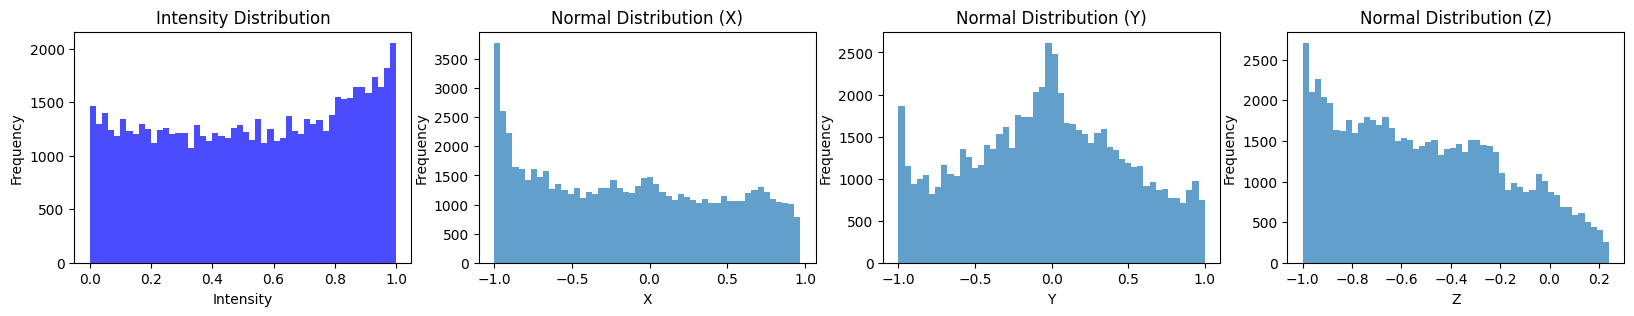

In [290]:
# Plot Intensity Distribution
plt.figure(figsize=(20, 3))

plt.subplot(1, 4, 1)
plt.hist(intensities, bins=50, color='blue', alpha=0.7)
plt.title("Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

data = [(0, 'X'), (1, 'Y'), (2, 'Z')]

for i, coord in data:
    plt.subplot(1, 4, 2 + i)
    plt.hist(np.stack(normals)[:,i], bins=50, alpha=0.7)
    plt.title(f"Normal Distribution ({coord})")
    plt.xlabel(coord)
    plt.ylabel("Frequency")

plt.show()